# Imagenet - LR 0.001

|S.No.|Optimization|Architecture|Pretrained|Pre-processing|Batch Count|Epochs|Loss Function|Optimizer|LR|Scheduler|Time per epoch|Test Acc|Val Acc|Overfitting| Underfitting|
|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|
|1|Basic|Resnet50|No|Convert To Tensor|128|30|CrossEntropyLoss|SGD|None|0.05|1.30|99.84|68.33|Yes|No|
|2|Resize Image|Resnet50|No|Resize Image|128|30|CrossEntropyLoss|SGD|None|0.05|1.30|99.86|69.89|Yes|No|
|3|Normalized Image|Resnet50|No|Normalized Image|128|30|CrossEntropyLoss|SGD|None|0.05|1.30|99.89|70.34|Yes|No|
|4|LR 0.001|Resnet50|No|Normalized Image|128|30|CrossEntropyLoss|SGD|None|0.001|1.30|80.27|69.88|Yes|No|

## Summary
- Reduced LR from 0.05 to 0.001 
- Zig zag pattern became a smooth curve
- Difference between Test and Val acc/loss was small till 10 epochs
- Again difference between test and val acc/loss started to increase leading to overfitting after 10 epochs
- Diff between test and val acc after 30 epochs is 10.38 only.
- Next is to reduce LR after 10 epochs to avoid overfitting.

## Install Packages

In [1]:
!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu118 # Install packages in the correct order
!pip install numpy==1.24.3
!pip install tqdm matplotlib pillow
!pip install seaborn scikit-learn

Looking in indexes: https://download.pytorch.org/whl/cu118


## Check for CUDA and set device

In [2]:
# Verify CUDA availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch version: 2.4.1+cu118
CUDA available: True
CUDA device: Tesla T4
Using device: cuda


## Import all packages

In [3]:
# Import all required libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import urllib.request
import zipfile
import shutil

## Verify installation and important package versions

In [4]:
# Verify installations
import numpy as np
print(f"Numpy version: {np.__version__}")

import torch
print(f"PyTorch version: {torch.__version__}")

import torchvision
print(f"Torchvision version: {torchvision.__version__}")

Numpy version: 1.24.3
PyTorch version: 2.4.1+cu118
Torchvision version: 0.19.1+cu118


In [5]:
## Application Constants
BATCH_SIZE = 128
NUM_CLASSES = 200
EPOCHS_COUNT = 30
LR = 0.001

## Download Dataset

In [6]:
# Download and extract Tiny ImageNet
def download_and_extract_tiny_imagenet():
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    zip_path = "tiny-imagenet-200.zip"
    extract_path = "tiny-imagenet-200"
    
    if not os.path.exists(extract_path):
        print("Downloading Tiny ImageNet...")
        urllib.request.urlretrieve(url, zip_path)
        
        print("Extracting files...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall("./")
        
        # Remove the zip file
        os.remove(zip_path)
        print("Dataset ready!")
    else:
        print("Dataset already exists!")
    
    return extract_path

In [7]:
# Prepare validation directory structure
def restructure_val_dir(dataset_path):
    val_dir = os.path.join(dataset_path, 'val')
    val_images_dir = os.path.join(val_dir, 'images')
    
    if os.path.exists(val_images_dir):
        # Read validation annotations file
        val_annotations_file = os.path.join(val_dir, 'val_annotations.txt')
        with open(val_annotations_file, 'r') as f:
            val_annotations = f.readlines()
        
        # Create class directories and move images
        for line in val_annotations:
            parts = line.strip().split('\t')
            img_name, class_id = parts[0], parts[1]
            
            # Create class directory if it doesn't exist
            class_dir = os.path.join(val_dir, class_id)
            os.makedirs(class_dir, exist_ok=True)
            
            # Move image to class directory
            src_path = os.path.join(val_images_dir, img_name)
            dst_path = os.path.join(class_dir, img_name)
            if os.path.exists(src_path):
                shutil.move(src_path, dst_path)
        
        # Remove the original images directory and annotations file
        shutil.rmtree(val_images_dir)
        os.remove(val_annotations_file)

In [8]:
# Download and prepare dataset
dataset_path = download_and_extract_tiny_imagenet()
restructure_val_dir(dataset_path)

Dataset already exists!


## Define Transformations

In [9]:
# Define data transforms
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Tiny ImageNet images are 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Prepare Dataset

In [10]:
# Load datasets
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')

train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(val_dir, transform=val_transform)


In [11]:
# Create data loaders
batch_size = BATCH_SIZE  # Increased batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


## Load Resnet50 Model

In [12]:
# Load ResNet50 with pretrained=False for training from scratch
model = torchvision.models.resnet50(weights='ResNet50_Weights.DEFAULT')
num_classes = NUM_CLASSES
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


## Define Loss Function and Optimizer

In [13]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR)

## Train the model

In [14]:
# Training function
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


In [15]:
# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


In [16]:
# Training loop
num_epochs = EPOCHS_COUNT
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")



Epoch 1/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.20it/s]


Train Loss: 5.1949 | Train Acc: 2.98%
Val Loss: 5.0052 | Val Acc: 8.80%

Epoch 2/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.38it/s]


Train Loss: 4.5699 | Train Acc: 20.39%
Val Loss: 4.0769 | Val Acc: 31.55%

Epoch 3/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.62it/s]


Train Loss: 3.5548 | Train Acc: 37.52%
Val Loss: 3.0647 | Val Acc: 44.26%

Epoch 4/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.80it/s]


Train Loss: 2.7325 | Train Acc: 47.28%
Val Loss: 2.4269 | Val Acc: 51.09%

Epoch 5/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.34it/s]


Train Loss: 2.2227 | Train Acc: 53.15%
Val Loss: 2.0245 | Val Acc: 56.21%

Epoch 6/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.81it/s]


Train Loss: 1.9303 | Train Acc: 57.02%
Val Loss: 1.8181 | Val Acc: 58.77%

Epoch 7/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.35it/s]


Train Loss: 1.7517 | Train Acc: 59.61%
Val Loss: 1.7113 | Val Acc: 60.35%

Epoch 8/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.45it/s]


Train Loss: 1.6260 | Train Acc: 61.54%
Val Loss: 1.6157 | Val Acc: 61.51%

Epoch 9/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.14it/s]


Train Loss: 1.5308 | Train Acc: 63.30%
Val Loss: 1.5461 | Val Acc: 63.13%

Epoch 10/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.84it/s]


Train Loss: 1.4522 | Train Acc: 64.72%
Val Loss: 1.4882 | Val Acc: 64.11%

Epoch 11/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.87it/s]


Train Loss: 1.3854 | Train Acc: 66.08%
Val Loss: 1.4395 | Val Acc: 65.16%

Epoch 12/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.46it/s]


Train Loss: 1.3284 | Train Acc: 67.30%
Val Loss: 1.4185 | Val Acc: 65.55%

Epoch 13/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.36it/s]


Train Loss: 1.2755 | Train Acc: 68.30%
Val Loss: 1.3802 | Val Acc: 66.20%

Epoch 14/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.49it/s]


Train Loss: 1.2290 | Train Acc: 69.42%
Val Loss: 1.3655 | Val Acc: 66.54%

Epoch 15/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.71it/s]


Train Loss: 1.1855 | Train Acc: 70.39%
Val Loss: 1.3307 | Val Acc: 67.05%

Epoch 16/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.86it/s]


Train Loss: 1.1486 | Train Acc: 71.11%
Val Loss: 1.5181 | Val Acc: 64.59%

Epoch 17/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.36it/s]


Train Loss: 1.1101 | Train Acc: 71.90%
Val Loss: 1.3043 | Val Acc: 67.51%

Epoch 18/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.33it/s]


Train Loss: 1.0789 | Train Acc: 72.70%
Val Loss: 1.2877 | Val Acc: 67.83%

Epoch 19/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.83it/s]


Train Loss: 1.0463 | Train Acc: 73.46%
Val Loss: 1.2762 | Val Acc: 68.07%

Epoch 20/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.73it/s]


Train Loss: 1.0149 | Train Acc: 74.17%
Val Loss: 1.2741 | Val Acc: 68.13%

Epoch 21/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.77it/s]


Train Loss: 0.9872 | Train Acc: 74.80%
Val Loss: 1.2613 | Val Acc: 68.02%

Epoch 22/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.64it/s]


Train Loss: 0.9596 | Train Acc: 75.56%
Val Loss: 1.2550 | Val Acc: 68.50%

Epoch 23/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.71it/s]


Train Loss: 0.9333 | Train Acc: 76.15%
Val Loss: 1.2387 | Val Acc: 68.84%

Epoch 24/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.83it/s]


Train Loss: 0.9062 | Train Acc: 76.80%
Val Loss: 1.2320 | Val Acc: 69.08%

Epoch 25/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.85it/s]


Train Loss: 0.8797 | Train Acc: 77.42%
Val Loss: 1.2323 | Val Acc: 69.19%

Epoch 26/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.89it/s]


Train Loss: 0.8572 | Train Acc: 78.00%
Val Loss: 1.2291 | Val Acc: 69.40%

Epoch 27/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.53it/s]


Train Loss: 0.8337 | Train Acc: 78.61%
Val Loss: 1.2269 | Val Acc: 69.27%

Epoch 28/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.65it/s]


Train Loss: 0.8122 | Train Acc: 79.15%
Val Loss: 1.2177 | Val Acc: 69.74%

Epoch 29/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.50it/s]


Train Loss: 0.7894 | Train Acc: 79.72%
Val Loss: 1.2132 | Val Acc: 69.67%

Epoch 30/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.86it/s]

Train Loss: 0.7669 | Train Acc: 80.27%
Val Loss: 1.2126 | Val Acc: 69.88%


## Plot Metrics

In [17]:
# Plot training and validation metrics
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

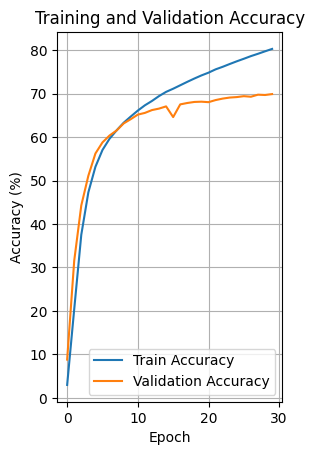

In [18]:
# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

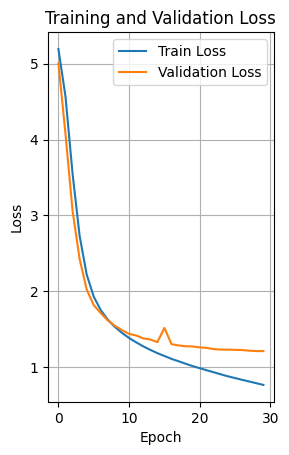

In [19]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

In [20]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

## Save Model

In [21]:
# Save the model
torch.save(model.state_dict(), 'resnet50_tiny_imagenet.pth')

## Plot Misclassified Images

In [22]:
def get_class_name_mapping(dataset_path):
    """
    Create mapping from wnid to human-readable class names using words.txt
    """
    words_file = os.path.join(dataset_path, 'words.txt')
    wnid_to_name = {}
    
    try:
        with open(words_file, 'r') as f:
            for line in f:
                wnid, names = line.strip().split('\t')
                # Take the first comma-separated name if multiple exist
                name = names.split(',')[0].strip()
                wnid_to_name[wnid] = name
    except FileNotFoundError:
        print(f"Warning: words.txt not found at {words_file}")
        # Create a simple mapping if words.txt is not available
        wnid_to_name = {class_id: class_id for class_id in train_dataset.classes}
    
    return wnid_to_name

In [23]:
def denormalize(tensor):
    """
    Denormalize the image tensor for visualization
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

In [24]:
def get_misclassified_images(model, val_loader, class_mapping, num_images=20):
    """
    Get misclassified images with their true and predicted labels
    """
    model.eval()
    misclassified_images = []
    true_classes = []
    pred_classes = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Find misclassified images
            mask = (predicted != labels)
            misclassified_idx = mask.nonzero(as_tuple=True)[0]
            
            for idx in misclassified_idx:
                if len(misclassified_images) >= num_images:
                    break
                
                # Get wnids
                true_wnid = train_dataset.classes[labels[idx].item()]
                pred_wnid = train_dataset.classes[predicted[idx].item()]
                
                # Get human-readable names
                true_class_name = class_mapping.get(true_wnid, true_wnid)
                pred_class_name = class_mapping.get(pred_wnid, pred_wnid)
                
                misclassified_images.append(images[idx].cpu())
                true_classes.append(true_class_name)
                pred_classes.append(pred_class_name)
                
            if len(misclassified_images) >= num_images:
                break
    
    return misclassified_images, true_classes, pred_classes

In [25]:
def plot_misclassified(images, true_classes, pred_classes, num_images=20):
    """
    Plot misclassified images in a grid
    """
    if len(images) < num_images:
        num_images = len(images)
    
    num_rows = (num_images + 4) // 5  # 5 images per row
    fig, axes = plt.subplots(num_rows, 5, figsize=(20, 4*num_rows))
    axes = axes.ravel()
    
    for idx in range(num_images):
        # img = denormalize(images[idx])
        img = images[idx]
        img = torch.clamp(img, 0, 1)
        
        # Format class names
        true_class = true_classes[idx]
        pred_class = pred_classes[idx]
        
        # Truncate long class names
        true_display = true_class[:25] + '...' if len(true_class) > 25 else true_class
        pred_display = pred_class[:25] + '...' if len(pred_class) > 25 else pred_class
        
        axes[idx].imshow(img.permute(1, 2, 0))
        axes[idx].axis('off')
        title = f'True: {true_display}\nPred: {pred_display}'
        axes[idx].set_title(title, fontsize=10, color='red', pad=10)
    
    # Turn off any unused subplots
    for idx in range(num_images, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

In [26]:
# Get class name mapping
class_mapping = get_class_name_mapping(dataset_path)

In [27]:
# Get misclassified images
misclassified_images, true_classes, pred_classes = get_misclassified_images(
    model, val_loader, class_mapping
)

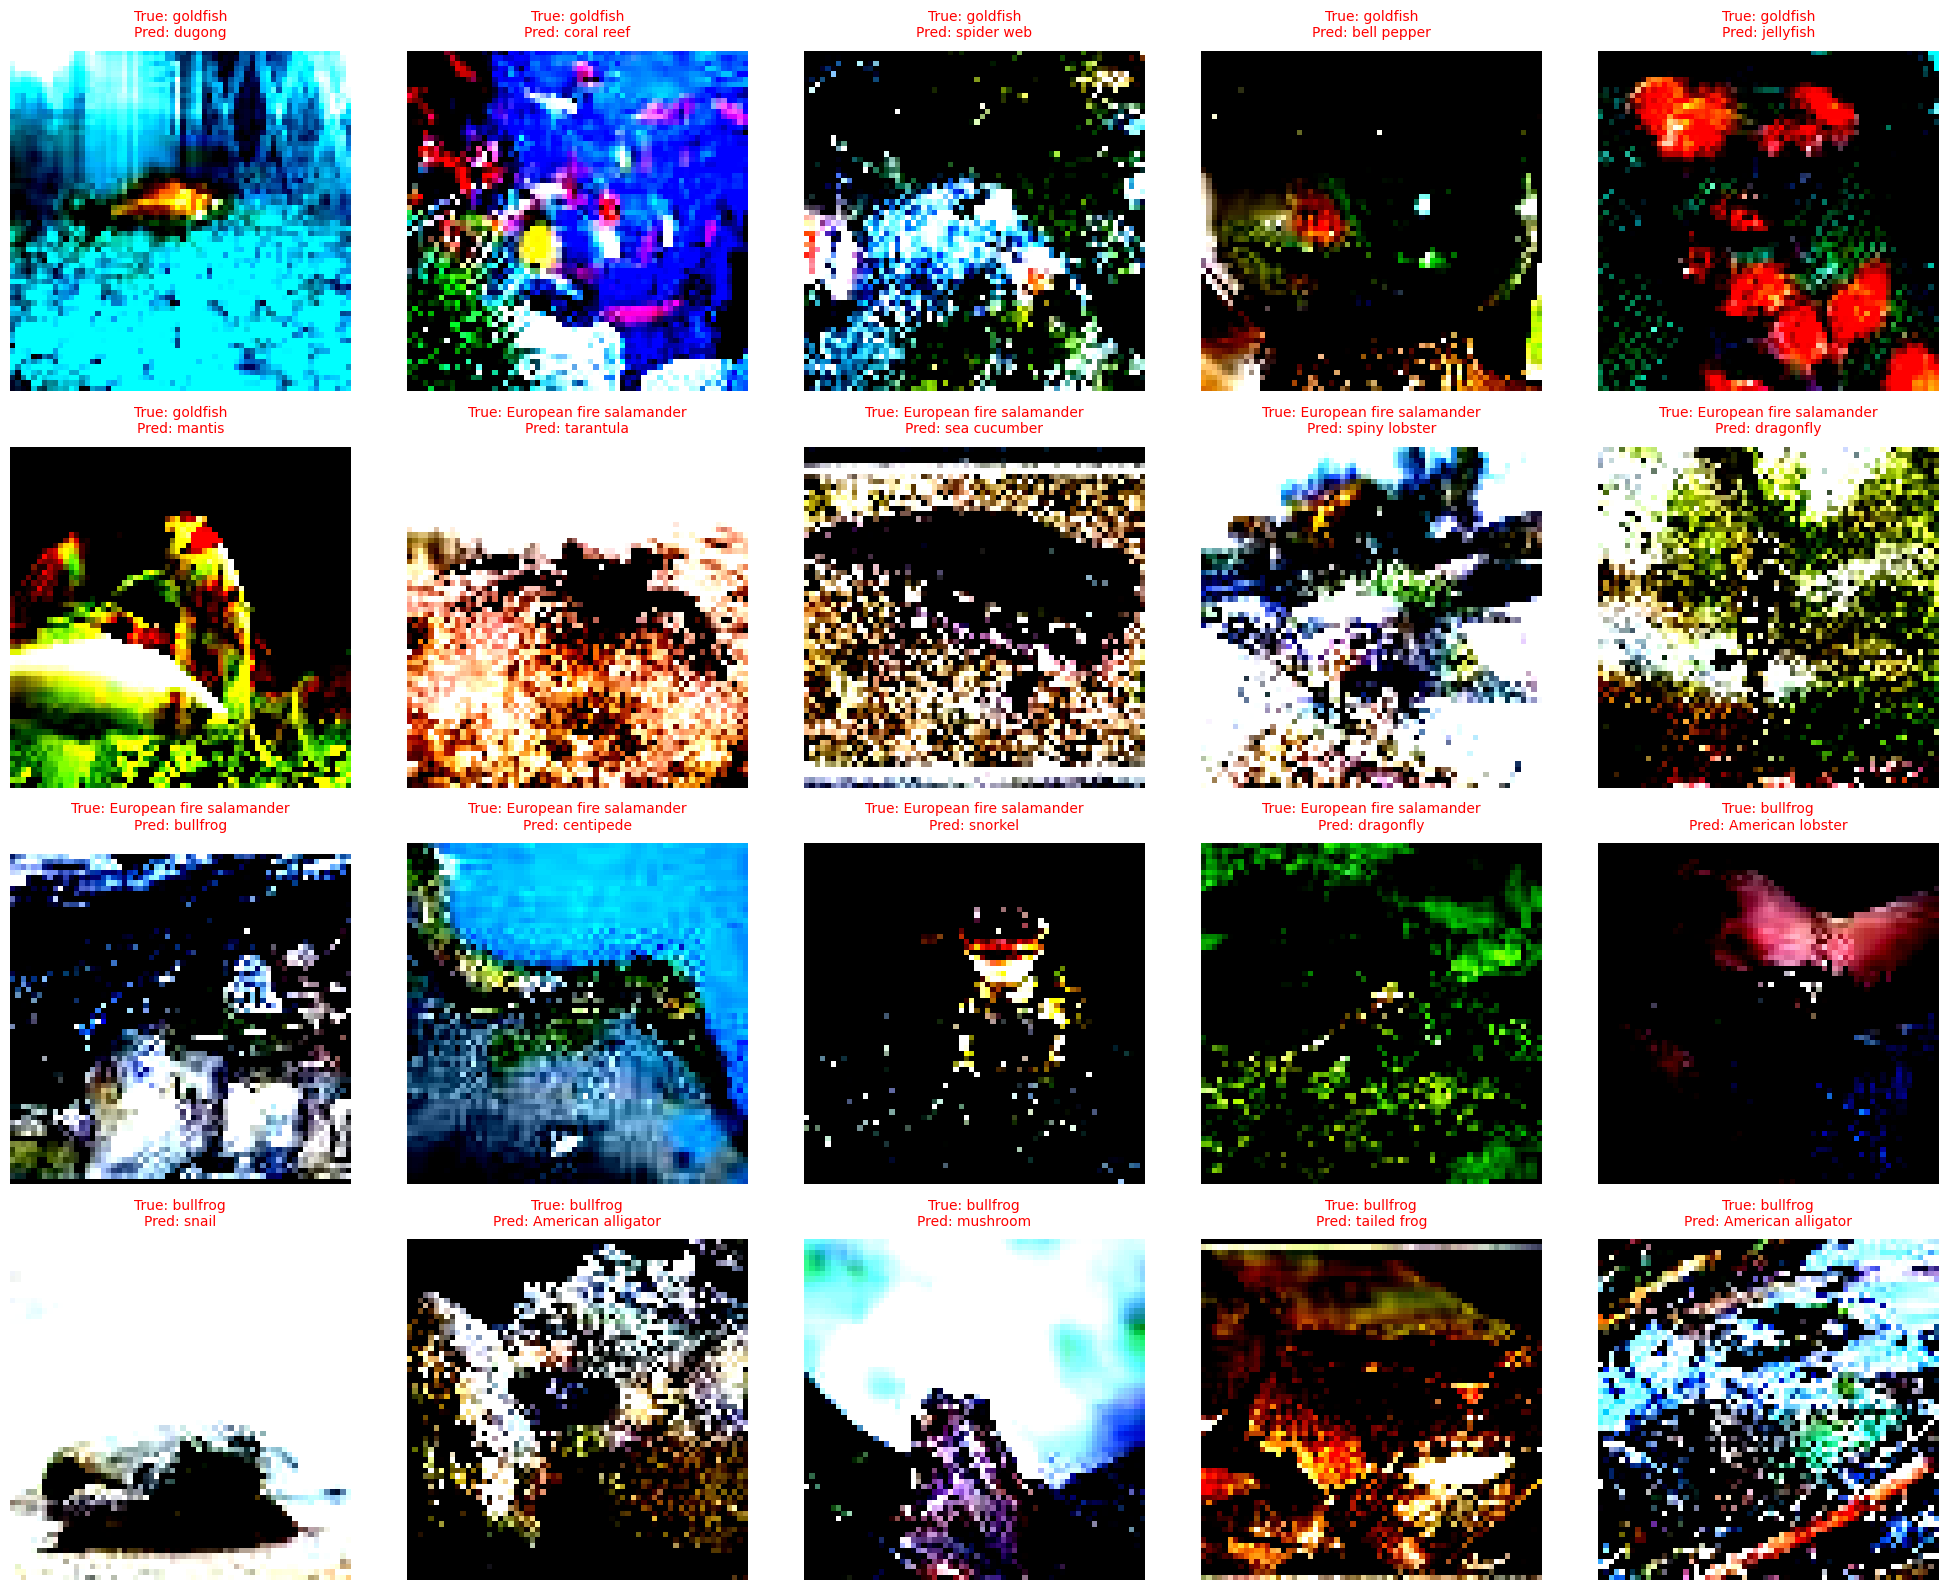

In [28]:
# Plot misclassified images
plot_misclassified(misclassified_images, true_classes, pred_classes)

In [29]:
# Print model accuracy
print("\nEvaluating model on validation set...")
model.eval()
correct = 0
total = 0
class_correct = {}
class_total = {}

with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Per-class accuracy
        for label, pred in zip(labels, predicted):
            label_name = class_mapping[train_dataset.classes[label.item()]]
            if label_name not in class_total:
                class_total[label_name] = 0
                class_correct[label_name] = 0
            class_total[label_name] += 1
            if label == pred:
                class_correct[label_name] += 1
                
# Overall accuracy
accuracy = 100 * correct / total
print(f"\nOverall Model Accuracy: {accuracy:.2f}%")

# Print per-class accuracy
print("\nPer-class Accuracy:")
accuracies = []
for class_name in class_total:
    class_acc = 100 * class_correct[class_name] / class_total[class_name]
    accuracies.append((class_name, class_acc))

# Sort by accuracy
accuracies.sort(key=lambda x: x[1], reverse=True)

# Print top 10 and bottom 10 classes
print("\nTop 10 Best Performing Classes:")
for class_name, acc in accuracies[:10]:
    print(f"{class_name[:40]:<40}: {acc:.2f}%")

print("\nBottom 10 Worst Performing Classes:")
for class_name, acc in accuracies[-10:]:
    print(f"{class_name[:40]:<40}: {acc:.2f}%")

# Analyze misclassifications
print("\nMost Common Misclassifications:")
misclass_count = {}
for true_class, pred_class in zip(true_classes, pred_classes):
    if true_class not in misclass_count:
        misclass_count[true_class] = {}
    if pred_class not in misclass_count[true_class]:
        misclass_count[true_class][pred_class] = 0
    misclass_count[true_class][pred_class] += 1

for true_class in misclass_count:
    print(f"\nTrue class: {true_class}")
    sorted_misclass = sorted(misclass_count[true_class].items(), 
                            key=lambda x: x[1], 
                            reverse=True)
    for pred_class, count in sorted_misclass[:3]:
        print(f"  Predicted as {pred_class}: {count} times")


Evaluating model on validation set...


100%|██████████| 79/79 [00:03<00:00, 21.99it/s]


Overall Model Accuracy: 69.88%

Per-class Accuracy:

Top 10 Best Performing Classes:
dugong                                  : 94.00%
gazelle                                 : 94.00%
gondola                                 : 94.00%
school bus                              : 94.00%
monarch                                 : 92.00%
sulphur butterfly                       : 90.00%
chimpanzee                              : 90.00%
bell pepper                             : 90.00%
goldfish                                : 88.00%
brain coral                             : 88.00%

Bottom 10 Worst Performing Classes:
military uniform                        : 46.00%
pop bottle                              : 46.00%
water jug                               : 46.00%
wooden spoon                            : 46.00%
convertible                             : 40.00%
pole                                    : 40.00%
lakeside                                : 38.00%
syringe                                 : 36

# ChapGPT

When training accuracy surpasses validation accuracy after 10 epochs, and the gap between them continues to increase, it indicates overfitting. Specifically, the model is learning the patterns in the training data well, but it is not generalizing effectively to the validation data. Here's a deeper look at what might be happening and how to address it:

What It Means:
Overfitting:

The model is memorizing the training data, which leads to very high performance on the training set but poor generalization to the validation set. This is the classic sign of overfitting, where the model starts to memorize specific details and noise in the training data, which doesn't apply to the unseen validation data.
Validation Performance Stagnates:

The model might struggle to find meaningful patterns in the validation set or simply hasn't learned the generalizable features. This causes the validation accuracy to stay relatively low or grow very slowly, even as training accuracy increases.
Lack of Regularization or Insufficient Data:

The model is likely too complex relative to the size and variability of the training data, or there’s a lack of regularization techniques to prevent it from fitting to the training data too closely.
What Can Be Done?
To address the increasing gap between training and validation accuracy and reduce overfitting, you can implement several techniques:

1. Regularization Techniques:
Dropout: Introduce dropout layers in the network. Dropout randomly sets some of the weights to zero during training, which forces the network to learn more robust features that generalize better.

How to do it: Dropout can be added in the fully connected layers, or at other places in the architecture.
Example: If using Keras/TensorFlow:
python
Copy
model.add(Dropout(0.5))  # 50% dropout rate
L2 Regularization (Weight Decay): Add L2 regularization to the weights to penalize large weight values. This can help prevent the model from overfitting by limiting the magnitude of the parameters.

How to do it: If using Keras/TensorFlow:
python
Copy
from tensorflow.keras import regularizers
model.add(Dense(128, kernel_regularizer=regularizers.l2(0.01)))
Early Stopping: Monitor the validation loss or accuracy, and stop training once the validation performance starts to plateau. This will prevent the model from continuing to train after it has started overfitting.

How to do it: Most deep learning frameworks allow easy implementation of early stopping:
python
Copy
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.fit(..., callbacks=[early_stopping])
2. Data Augmentation:
Increase data variety: When the dataset is small, augmenting the training data by applying random transformations like rotations, flipping, zooming, and cropping can help the model generalize better.
How to do it: In Keras/TensorFlow, you can use the ImageDataGenerator class for real-time data augmentation:
python
Copy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2, horizontal_flip=True)
datagen.fit(X_train)
3. Use a Simpler Model:
If the model is too complex for the data, consider reducing the model's capacity by decreasing the number of layers or parameters.
How to do it: You can try a smaller network or use a smaller variant of ResNet (e.g., ResNet18 or ResNet34 instead of ResNet50).
4. Learning Rate Adjustments:
Learning rate decay: Using a learning rate scheduler or adaptive learning rates (like with the Adam optimizer) can help improve generalization and reduce overfitting. Sometimes, lowering the learning rate after a few epochs helps stabilize training and prevent the model from fitting too quickly to the training data.
How to do it: You can apply a learning rate schedule, for instance, reduce the learning rate every few epochs.
python
Copy
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
5. Cross-Validation:
Use cross-validation to get a more robust estimate of model performance. If you're using a small dataset like ImageNet Tiny, cross-validation can help in evaluating the model on multiple different subsets of data.
How to do it: Split your dataset into k folds and train the model on different folds to reduce the risk of overfitting to any single validation set.
6. Batch Normalization:
Batch normalization can help stabilize training and potentially improve the generalization of the model by normalizing the activations within each mini-batch.
How to do it: Ensure that your ResNet50 model (if not already done) includes batch normalization layers or add them manually.
7. Increase Dataset Size:
If possible, increase the dataset size. This can be done either by collecting more data or using pre-trained models and applying transfer learning. If your dataset is small, transfer learning with a pre-trained model (e.g., ResNet50 trained on ImageNet) can allow the model to use knowledge learned from a larger dataset and fine-tune it for your task.
How to do it: Use pre-trained weights for ResNet50, then fine-tune the model on your specific task.
Summary:
The increasing gap between training and validation accuracy is a clear sign of overfitting. To combat this, you can:

Implement regularization (dropout, L2 regularization).
Apply data augmentation to artificially increase the dataset size.
Use early stopping to prevent overtraining.
Adjust the learning rate or use a more advanced optimizer.
Consider using a simpler model or smaller versions of ResNet.
Explore transfer learning if your dataset is small.
By employing these techniques, you should be able to reduce the overfitting and improve the model's ability to generalize to unseen data.